# Importer les packages

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import sweetviz as sv
import missingno as msno
import time 
import sys
import os
import csv

import requests
import re

from sklearn.compose import make_column_selector, ColumnTransformer, make_column_transformer
# sklearn.compose: The sklearn.compose module is a submodule of the sklearn library for machine learning in Python. It provides functions for creating complex preprocessing and modeling pipelines.
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
#sklearn.preprocessing: The sklearn.preprocessing module is a submodule of the sklearn library that provides functions for preprocessing data, such as scaling and normalizing features, imputing missing values, and encoding categorical variables.
from sklearn.linear_model import Ridge,LinearRegression,Lasso, ElasticNet
# sklearn.linear_model: The sklearn.linear_model module is a submodule of the sklearn library that provides functions for fitting linear models for regression and classification.
from sklearn.pipeline import make_pipeline
# sklearn.pipeline: The sklearn.pipeline module is a submodule of the sklearn library that provides functions for creating and working with pipelines of transformers and models.
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve, RandomizedSearchCV, cross_val_score, KFold
# sklearn.model_selection: The sklearn.model_selection module is a submodule of the sklearn library that provides functions for splitting data into training and test sets, evaluating models using cross-validation, and hyperparameter tuning.
from sklearn.dummy import DummyRegressor
# sklearn.dummy: The sklearn.dummy module is a submodule of the sklearn library that provides simple dummy models for regression and classification.


from sklearn.impute import SimpleImputer
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import pickle


# Lire les données

In [7]:
df = pd.read_csv('/home/apprenant/Documents/DATA/loan_project/SBAnational.csv')

df['ApprovalFY'] = df['ApprovalFY'].replace('A', '', regex=True).astype(int)

/tmp/ipykernel_5547/2766766313.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/apprenant/Documents/DATA/loan_project/SBAnational.csv')


# Nettoyage des données

In [8]:
# create a list of all numeric columns
columns_to_transform_to_int = ["DisbursementGross","BalanceGross","ChgOffPrinGr","GrAppv","SBA_Appv"]


for col in columns_to_transform_to_int:
    df[col] = df[col].str.replace("$", "")
    df[col] = df[col].str.replace(",", "")
    df[col] = df[col].astype(float)
    

df['Term'] = df['Term'].astype(int)

df['LowDoc'] = df['LowDoc'].replace({'0': 'N'})
df = df[df['LowDoc'].isin(['N','Y'])]
df['RevLineCr'] = df['RevLineCr'].replace({'0': 'N', 'T':'Y'})
df = df[df['RevLineCr'].isin(['N','Y'])]

dictionnaire =  {"11":"Agriculture, forestry, fishing and hunting","72":"Accommodation and food services","21":"Mining, quarrying, and oil and gas extraction","22":
"Utilities","23":"Construction","31":"Manufacturing","32":"Manufacturing","33":"Manufacturing","42":"Wholesale trade","44":"Retail trade","45":"Retail trade","48":" Transportation and warehousing", "49":"Transportation and warehousing", "51":"Information","52":"Finance and insurance", "53":"Real estate and rental and leasing","54":"Professional, scientific, and technical services","55":"Management of companies and enterprises","56":"Administrative and support and waste management and remediation services","61":"Educational services","62":"Health care and social assistance","71":"Arts, entertainment, and recreation","81":"Other services (except public administration)", "92": "Public administration", "0" : "Other"}

df['NAICS'] = df['NAICS'].astype(str).str[:2]

df["NAICS"] = df["NAICS"].map(dictionnaire)

cols_to_drop = ['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'BankState', 'ApprovalDate', 'RetainedJob','ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'SBA_Appv', 'ChgOffPrinGr']
df_cleaned = df.copy()
df_cleaned.drop(columns=cols_to_drop, inplace=True)

df_cleaned.dropna(subset=['MIS_Status'], inplace=True)


/tmp/ipykernel_5547/2495417656.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "")


# Préparation à la modélisation

In [9]:
y = df_cleaned.MIS_Status
X = df_cleaned.drop(columns=['MIS_Status'])

# Pipeline

In [10]:
def make_pipeline_to_ML(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=42)
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude= np.number)
    numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler(with_mean=False))
    categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))
    preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                    (categorical_pipeline, categorical_features)
                                    )
    return preprocessor, X_train, X_test, y_train, y_test


# Create the pipeline
preprocessor, X_train, X_test, y_train, y_test = make_pipeline_to_ML(X,y)

In [11]:
X_train_ML = X_train.head(10000)
y_train_ML = y_train.head(10000)

# XGBClassifier
!['XGD'](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRD7Jd4XJNHb0wB_i4V7NFA_qrc6LTEuxPhgw&usqp=CAU)

### Les hyperparamètres les plus importants pour XGBoost Classifier sont :

- `n_estimators` : le nombre d'arbres de décision dans le modèle
- `learning_rate` : le taux d'apprentissage utilisé pour mettre à jour les poids des modèles
- `max_depth` : la profondeur maximale de chaque arbre de décision
- `subsample` : la proportion d'échantillons utilisés pour construire chaque arbre
- `colsample_bytree` : la proportion de colonnes utilisées pour construire chaque arbre
- `gamma` : un paramètre qui régule la complexité de chaque arbre.
- `reg_alpha` : la régularisation L1 sur les poids
- `reg_lambda` : la régularisation L2 sur les poids.
- `scale_pos_weight` : pour gérer les déséquilibres de classe
- `objective` : choisir l'objectif de la régression, logistique pour la classification binaire, softmax pour la classification multi-classe.

# Encodage de la target (0,1) à la place de 'PIF',..

In [12]:
from sklearn.preprocessing import LabelEncoder

# initialize the label encoder
le = LabelEncoder()

# fit and transform the y labels
y_train_ML = le.fit_transform(y_train_ML)
y_test = le.transform(y_test)


# Rechercher les meilleurs paramètres

In [13]:
from xgboost import XGBClassifier
clf_egb_RGCV = make_pipeline(preprocessor, XGBClassifier( random_state=42, objective = 'binary:logistic', tree_method = 'hist'))
params = {
        'xgbclassifier__max_depth':[1,5,10], 
        #'xgbclassifier__objective' : ['binary:logistic'],
        'xgbclassifier__n_estimators' : [100,200],
        'xgbclassifier__learning_rate' : [0.2,0.3],
        #'xgbclassifier__tree_method': ['hist']   # this will make it faaaaaaaaaster
        }
 # Create the grid search object
grid_seargrid_search_xgboostch = GridSearchCV(clf_egb_RGCV, params, cv=5, n_jobs = -1, verbose=1)

In [14]:
# Fit the grid search to the data
grid_seargrid_search_xgboostch.fit(X_train_ML, y_train_ML)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler(with_mean=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fba341909a0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleI...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.2, 0.3],
                         'xgbclassifier__max_depth': [1, 5, 10],
                         'xgbclassifier__n_estimators': [100, 200]},
             verbose=1)

In [15]:
# Print the best parameters and the best score
print("Best parameters: ", grid_seargrid_search_xgboostch.best_params_)
print("Best score: ", grid_seargrid_search_xgboostch.best_score_)

Best parameters:  {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}
Best score:  0.9311


In [16]:
# Get the accuracy score on the test data
accuracy = grid_seargrid_search_xgboostch.score(X_test, y_test)

# Print the accuracy score
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 93.19%


# Application de nos meilleurs paramètres

In [17]:
clf_egb_RGCV = make_pipeline(preprocessor, XGBClassifier(random_state=42, 
                                                max_depth = 10, 
                                                n_estimators = 100,
                                                #min_child_weight = 4800,
                                                #subsample = 0.8,
                                                #colsample_bytree = 0.8,
                                                #scale_pos_weight=1.375,
                                                objective='binary:logistic',
                                                learning_rate=0.2,
                                                tree_method = 'hist',
                                                n_jobs=-1))

# Fit the pipeline on the training data
clf_egb_RGCV.fit(X_train_ML, y_train_ML)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fba341909a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_freque...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.2,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                               predictor='auto', random_state=42, ...))])

[learning_curve] Training set sizes: [ 800 1600 2400 3200 4000 4800 5600 6400 7200 8000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.8s finished


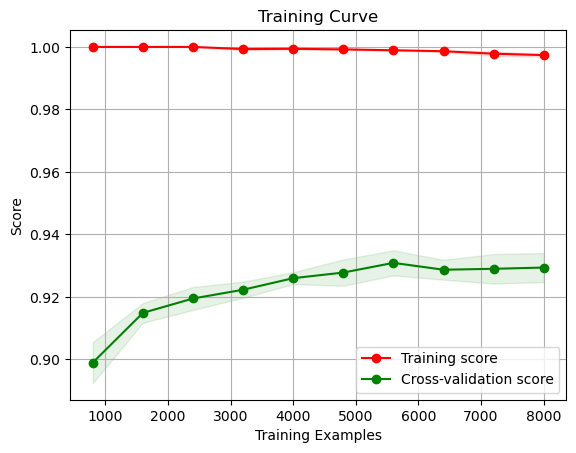

In [18]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt



# Generate the training curve
train_sizes, train_scores, test_scores = learning_curve(
    clf_egb_RGCV, X_train_ML, y_train_ML, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1, 10), verbose=1)

# Plot the training curve
plt.figure()
plt.title("Training Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()


# PCA

In [19]:
numeric_features = list(X.select_dtypes(include=['int', 'float']).columns)
len(numeric_features)

8

In [30]:
####### Analyse best PCA


from sklearn.decomposition import PCA

n_dims = X_train.shape[1]
def make_pipeline_to_ML(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=42)
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude= np.number)
    numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler(with_mean=False),model = PCA(n_components=n_dims))
    categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))
    preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                    (categorical_pipeline, categorical_features)
                                    )
    return preprocessor, X_train, X_test, y_train, y_test





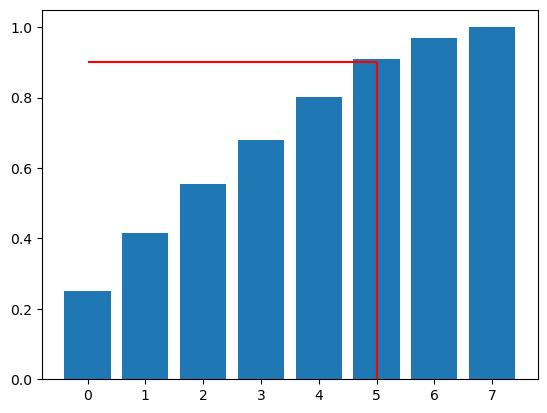

In [34]:
from sklearn.preprocessing import  StandardScaler
import numpy as np
std = StandardScaler()
X_train.dropna( inplace=True)
X_train_standard = std.fit_transform(X_train[numeric_features])

from sklearn.decomposition import PCA
# Choisir le nb de composants
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

In [29]:

preprocessor, X_train, X_test, y_train, y_test = make_pipeline_to_ML(X,y)

model = PCA(n_components=X_train.shape[1])
model.fit(preprocessor.fit_transform(X_train))

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

TypeError: make_pipeline() got an unexpected keyword argument 'model'